---
title: "Find Swing Landmarks"
author: "Ali Zaidi"
date: "2025-12-8"
categories: [Data Engineering, Automated Annotation, Exploratory Data Analysis]
description: "We need a more reliable way to index into the swing -- looking for the start, top of backswing and finish"
format:
  html:
    code-fold: true
jupyter: python3
---

In [5]:
#| include: false
from fastai.vision.all import *
from eagle_swing.data_class import *
from eagle_swing.video_utils import *
from eagle_swing.find_landmarks import *

In [6]:
#| include: false
# plot_feature_comparison(
#     SwExt_list, 
#     'hip_angle',
#     'hip_angle_acc',
#     'hip_angle_vel',
#     'left_arm_angle',
#     'left_leg_angle',
#     'right_arm_angle',
#     'right_leg_angle',
#     'right_arm_angle_vel',
#     'right_arm_angle_acc',
#     'left_side_bend',
#     'right_side_bend',
#     'x_factor',
#     'shoulder_angle',
#     'shoulder_angle_vel',
#     'shoulder_angle_acc',
#     'right_side_bend',
#     'left_side_bend',
#     # 'vertical_extension',
#     # 'vertical_extension_vel',
#     # 'vertical_extension_acc',
#     # 'x_factor',
#     # 'x_factor_vel',
#     # 'x_factor_acc',
#     # 'x_torque',
    
#     #attr_name='metrics',
#     instance_labels=clip_names,
#     markers=[25, 38, 48, 55],
# )


# def plot_feature_comparison(instances, *features, attr_name='data',
#                             instance_labels=None, figsize=None,
#                             markers=None,
#                             marker_kwargs=None,
#                             legend_side='right'):
#     """
#     Plots specified features vertically, comparing multiple class instances on each plot.
    
#     Args:
#         instances (list): List of 2-6 class instances.
#         *features (str): Variable number of feature names (keys) to extract from the attribute.
#         attr_name (str): The name of the attribute to index into (default: 'data').
#                          e.g., if you access instance.metrics['velocity'], attr_name='metrics'.
#         instance_labels (list, optional): List of strings to label the instances in the legend.
#         figsize (tuple, optional): Figure size override. Defaults to auto-scaled height.
#     """
#     num_features = len(features)
#     if num_features == 0:  
#         print("No features provided to plot.")
#         return

#     # Set up the vertical subplot layout
#     # Dynamically scale height: 3 inches per feature is usually a good readable standard
#     fig_height = 3 * num_features
#     if figsize is None:
#         figsize = (12, fig_height)
        
#     fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=figsize, sharex=True)
    
#     # Ensure axes is iterable even if there's only one feature
#     if num_features == 1:
#         axes = [axes]
        
#     # Generate default labels if none provided
#     if instance_labels is None:
#         instance_labels = [f"Instance {i+1}" for i in range(len(instances))]
#     if marker_kwargs is None:
#         colors = ['red', 'blue', 'green', 'yellow']
#         marker_kwargs = [dict(color=colors[x], linestyle='--', linewidth=1) for x in range(len(colors))]
#     # Loop through each feature (subplot)
#     for ax, feature in zip(axes, features):
#         ax.set_title(f"Feature: {feature}", fontsize=11, fontweight='bold')
#         ax.set_ylabel("Value")
#         2
#         # Loop through each class instance (line in the plot)
#         for i, instance in enumerate(instances):
#             try:
#                 # 1. Access the attribute (e.g., instance.data)
#                 #container = instance#getattr(instance, attr_name)
#                 # 2. Index into the attribute (e.g., instance.data['velocity'])
#                 data_array = getattr(instance, feature)
#                 #print(data_array.shape){
                
#                 # Plotting logic
#                 ax.plot(data_array, label=instance_labels[i], alpha=0.8, linewidth=1.5)
                
#             except KeyError:
#                 print(f"Warning: Feature '{feature}' not found in instance {i+1}.")
#             #except AttributeError:
#             #    print(f"Error: Instance {i+1} does not have attribute '{attr_name}'.")
#                 # add vertical marker on this subplot
#         if markers:
#             if type(markers) == list:
#                 [ax.axvline(marker, **marker_kwargs[idx]) for idx, marker in enumerate(markers)]
#             else: 
#                 ax.axvline(markers, **marker_kwargs)
            
#         ax.grid(True, alpha=0.3)
#         ax.legend(loc=f'upper {legend_side}', fontsize='small', framealpha=0.9)

#     # Label the bottom x-axis only
#     axes[-1].set_xlabel("Index / Frame")
    
#     plt.tight_layout()
#     plt.show()


In [7]:
plt.style.use('dark_background')

## Lets find the top of the backswing

In [31]:
# df = pd.read_csv('test_df.csv')
base_path = '../../../data/full_videos/ymirza'
#day_path = f"{base_path}/sep14"
#cleaned_df_paths = [file for file in get_files(day_path, extensions='.csv') if file.name == 'clean_lbls.csv']
cleaned_df_paths = [file for file in get_files(base_path, extensions='.csv') if file.name == 'clean_lbls.csv']
df_holder = []
for df_path in cleaned_df_paths:
    df_holder.append(pd.read_csv(df_path))
cleaned_df = pd.concat(df_holder).reset_index(drop=True)
cleaned_df['swing_day'] = cleaned_df.pkl_path.map(lambda x: x.split('/')[0])
cleaned_df['pkl_path'] = cleaned_df.pkl_path.map(lambda x: f'{base_path}/{x}')
before_increment = 20
after_increment = 20
cleaned_df['start_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] - before_increment
cleaned_df['end_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] + after_increment
df5 = cleaned_df[cleaned_df.score.map(lambda x: x == 5)]
df1 = cleaned_df[cleaned_df.score.map(lambda x: x == 1)]
test_df = pd.concat([df5.iloc[:3], df1.iloc[:3]]).reset_index(drop=True)
rand_idxs = np.random.randint(0, len(cleaned_df), 6)
test_df = cleaned_df.iloc[rand_idxs]

SwExt_list = []
for idx, row in test_df.iterrows():
    SwExt_list.append(SwingExtractor(row))
clip_names = [SwExt_list[x].clip_name for x in range(len(SwExt_list))]
print(clip_names)

['IMG_1092_swing_2_score_4', 'IMG_1273_swing_6_score_4', 'IMG_1183_swing_3_score_1', 'IMG_1023_swing_10_score_3', 'IMG_1023_swing_11_score_2', 'IMG_1091_swing_0_score_2']


In [32]:
frames_list = []
fps_list = []
for idx, row in test_df.iterrows():
    video_path = f"{row.pkl_path[:-3]}mp4"
    frames, fps = get_frames(video_path,
                            start_idx=row.start_idx,
                             num_frames=row.end_idx - row.start_idx,
                             show_progress=False,
                             resize_dim=(512,512)
                            )
    frames_list.append(frames)
    fps_list.append(fps)
view_videos_grid(frames_list)

In [36]:
complex_backswing_top_frames = [get_top_idx(SwExt_list[x].kps.r_wrist, 
             y_axis_only=True,
            thresh_value=0.01) for x in range(len(SwExt_list))]
complex_backswing_top_frames

[28, 34, 34, 29, 29, 33]

In [37]:
backswing_top_idxs = [np.argmin(SwExt_list[x].kps.r_wrist[:, :2].sum(axis=1)) for x in range(len(SwExt_list))]
backswing_top_idxs

[28, 34, 34, 29, 30, 33]

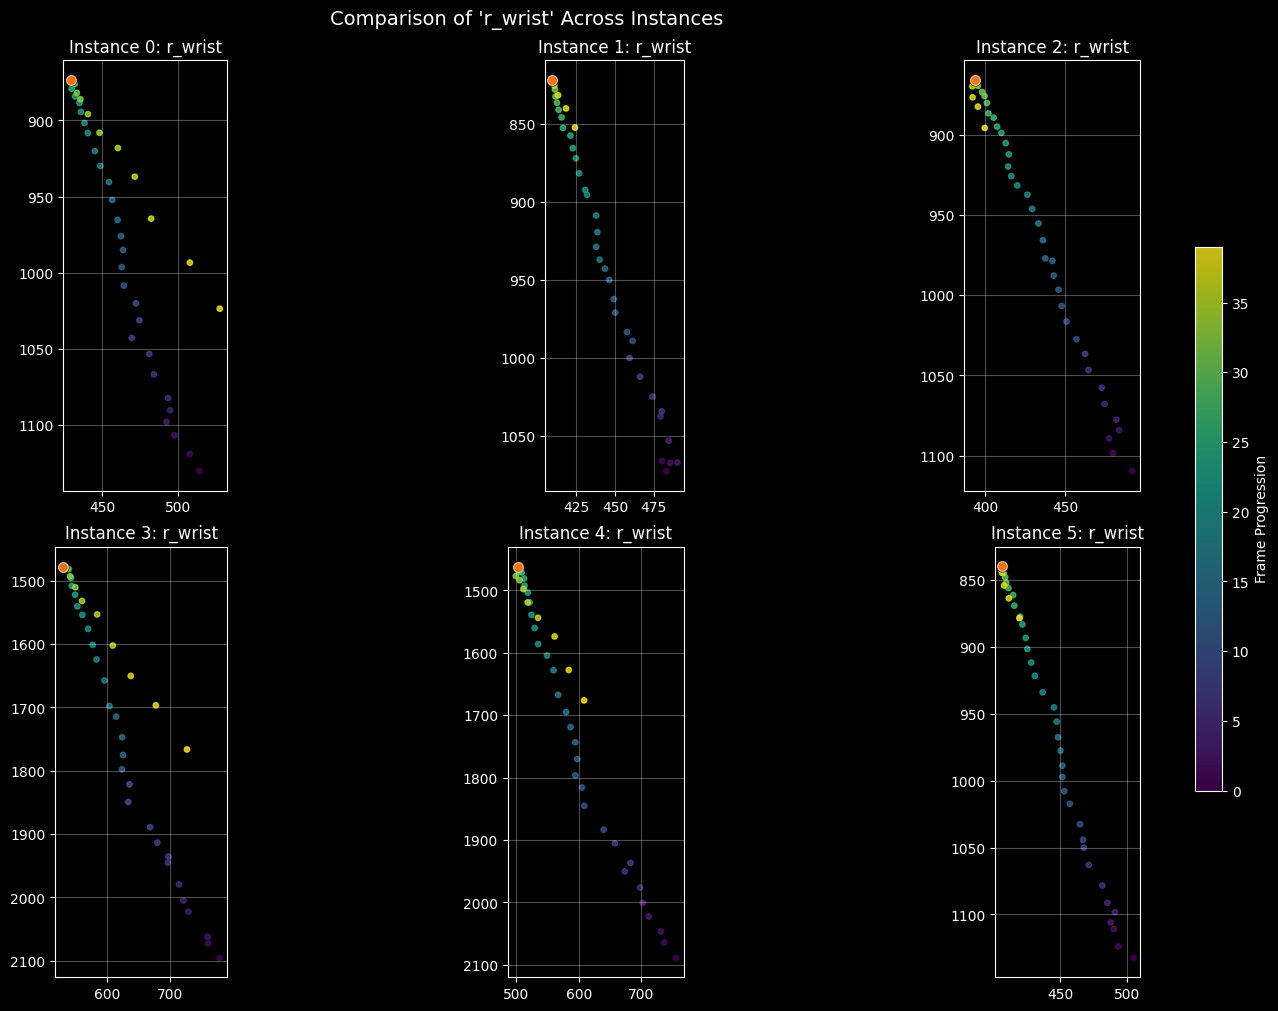

In [38]:
highlight_frames = [np.argmax(SwExt_list[x].kps.r_wrist[:, :2].sum(axis=1)) for x in range(len(SwExt_list))]
plot_feature_across_instances(SwExt_list,
                              feature_name='r_wrist',
                              highlight_frames=backswing_top_idxs,
                             highlight_frames_orange=complex_backswing_top_frames)

## Lets find the contact frame

In [41]:
before_increment = -20
after_increment = 40
cleaned_df['start_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] - before_increment
cleaned_df['end_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] + after_increment
df5 = cleaned_df[cleaned_df.score.map(lambda x: x == 5)]
df1 = cleaned_df[cleaned_df.score.map(lambda x: x == 1)]
test_df = pd.concat([df5.iloc[:3], df1.iloc[:3]]).reset_index(drop=True)
test_df = cleaned_df.iloc[rand_idxs]

SwExt_list = []
for idx, row in test_df.iterrows():
    SwExt_list.append(SwingExtractor(row))
clip_names = [SwExt_list[x].clip_name for x in range(len(SwExt_list))]
print(clip_names)

['IMG_1092_swing_2_score_4', 'IMG_1273_swing_6_score_4', 'IMG_1183_swing_3_score_1', 'IMG_1023_swing_10_score_3', 'IMG_1023_swing_11_score_2', 'IMG_1091_swing_0_score_2']


In [42]:
frames_list = []
for idx, row in test_df.iterrows():
    video_path = f"{row.pkl_path[:-3]}mp4"
    frames, fps = get_frames(video_path,
                            start_idx=row.start_idx,
                             num_frames=row.end_idx - row.start_idx,
                             show_progress=False,
                             resize_dim=(512,512)
                            )
    frames_list.append(frames)
view_videos_grid(frames_list)

In [43]:
[np.argmax(SwExt_list[x].kps.r_wrist[:, :2].sum(axis=1)) for x in range(len(SwExt_list))]

[6, 9, 10, 5, 7, 10]

In [44]:
[get_top_idx(SwExt_list[x].kps.r_wrist, 
             y_axis_only=True,
            thresh_value=0.01) for x in range(len(SwExt_list))]

[8, None, None, 17, 10, 12]

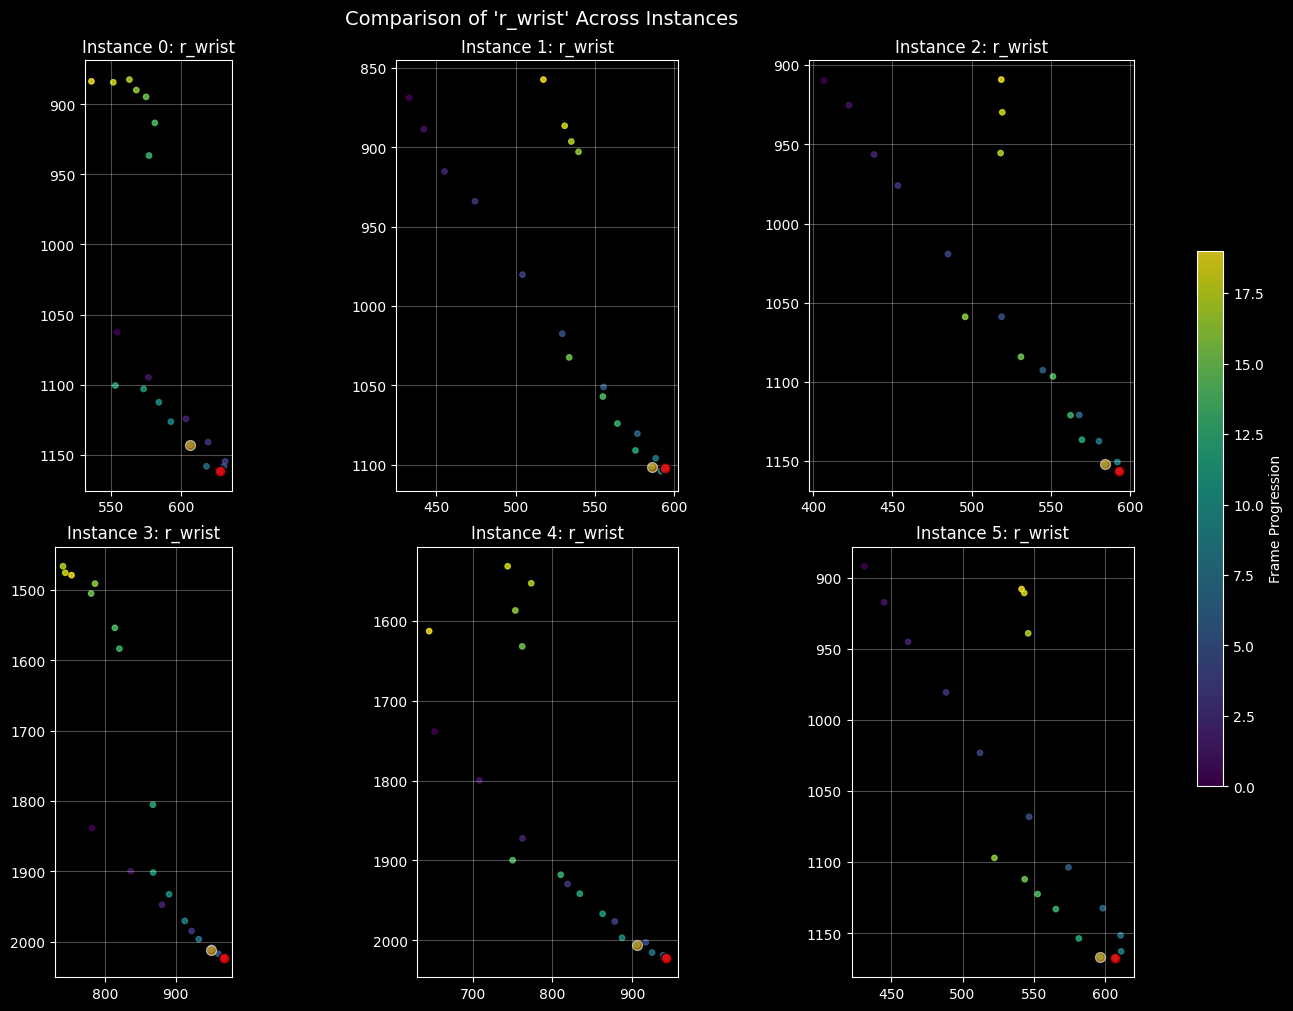

In [45]:
contact_idxs = [8,11,11,7,9,11]
highlight_frames = [np.argmax(SwExt_list[x].kps.r_wrist[:, :2].sum(axis=1)) for x in range(len(SwExt_list))]
plot_feature_across_instances(SwExt_list,
                              feature_name='r_wrist',
                              highlight_frames=highlight_frames,
                             highlight_frames_orange=contact_idxs)

## Now lets look at just top of backswing to contact

In [18]:
complex_backswing_top_frames, highlight_frames

([34, None, 30, 31, 35, 31], [0, 1, 5, 0, 0, 8])

In [46]:
# 20 frames before the first wrist over shoulder
top_frame = np.array(backswing_top_idxs) - 20
#top_frame = np.array(backswing_top_idxs) - 20
#bottom_frame = np.array(contact_idxs) + 20
bottom_frame = np.array(highlight_frames) + 20
bottom_frame - top_frame

array([18, 15, 16, 16, 17, 17])

In [47]:
top_frame, bottom_frame

(array([ 8, 14, 14,  9, 10, 13]), array([26, 29, 30, 25, 27, 30]))

In [72]:
frames_list = []
for idx, row in test_df.reset_index(drop=True).iterrows():
    video_path = f"{row.pkl_path[:-3]}mp4"
    frames, fps = get_frames(video_path,
                            start_idx=row.start_idx + top_frame[idx] - 20 ,
                             num_frames=bottom_frame[idx] - top_frame[idx] + 3,
                             show_progress=False,
                            )
    frames_list.append(frames)
view_videos_grid(frames_list)

## Lets find the start of the swings frame

In [ ]:
before_increment = 90
after_increment = 0
cleaned_df['start_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] - before_increment
cleaned_df['end_idx'] = cleaned_df['first_higher_wrists_backswing_frame'] + after_increment
df5 = cleaned_df[cleaned_df.score.map(lambda x: x == 5)]
df1 = cleaned_df[cleaned_df.score.map(lambda x: x == 1)]
test_df = pd.concat([df5.iloc[:3], df1.iloc[:3]]).reset_index(drop=True)

SwExt_list = []
for idx, row in test_df.iterrows():
    SwExt_list.append(SwingExtractor(row))
clip_names = [SwExt_list[x].clip_name for x in range(len(SwExt_list))]
frames_list = []
for idx, row in test_df.iterrows():
    video_path = f"{row.pkl_path[:-3]}mp4"
    frames, fps = get_frames(video_path,
                            start_idx=row.start_idx,
                             num_frames=row.end_idx - row.start_idx,
                             show_progress=False,
                            )
    frames_list.append(frames)
view_videos_grid(frames_list)
print(clip_names)

In [ ]:
start_frame_idxs = [15, 16, 20, 5, 15, 14] 

In [ ]:
#highlight_frames = [np.argmax(SwExt_list[x].kps.r_wrist[:, :2].sum(axis=1)) for x in range(len(SwExt_list))]
plot_feature_across_instances(SwExt_list,
                              feature_name='r_wrist',
                              highlight_frames=start_frame_idxs,#[10]*6,
                              highlight_frames_orange=[80]*6,
                             # highlight_frames=highlight_frames,
                             #highlight_frames_orange=contact_idxs
                              #smooth=False,
                              #smooth_window=11
                             )

In [ ]:
print(SwExt_list[0].clip_name)
plot_feature_trajectories(SwExt_list[0],
                         highlight_frame=15)

In [ ]:
print(SwExt_list[1].clip_name)
plot_feature_trajectories(SwExt_list[1],
                         highlight_frame=7)